# Make logoplots showing key sites of escape

In [1]:
import functools
import itertools
import operator
import os

import altair as alt

import dmslogo
import dmslogo.colorschemes

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd
import yaml

_ = alt.data_transformers.disable_max_rows()
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
min_entry = -3
min_ACE2 = -3
n_sites_to_show = 10

In [3]:
# per_antibody_escape = pd.read_csv("../results/summaries/antibody_escape.csv")
per_antibody_escape = pd.read_csv(snakemake.input.per_antibody_escape)

In [4]:
per_antibody_escape = per_antibody_escape.dropna()

filtered_df = per_antibody_escape[
    (per_antibody_escape['spike mediated entry'] >= min_entry) &
    (per_antibody_escape['ACE2 binding'] >= min_ACE2)
]

/tmp/ipykernel_26798/2022575420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["color"] = (


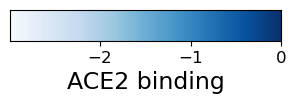

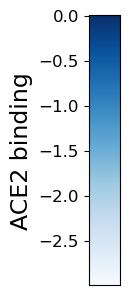

In [5]:
# for coloring by ACE2 binding
ace2_colormap = dmslogo.colorschemes.ValueToColorMap(
    minvalue=max(-4, filtered_df["ACE2 binding"].min()),
    maxvalue=0,
    cmap="Blues",
)

filtered_df["color"] = (
    filtered_df["ACE2 binding"]
    .clip(lower=ace2_colormap.minvalue, upper=ace2_colormap.maxvalue)
    .map(ace2_colormap.val_to_color)
)

for orientation in ["horizontal", "vertical"]:
    fig, _ = ace2_colormap.scale_bar(
        orientation=orientation, label="ACE2 binding",
    )
    svg = os.path.join("results/escape_logos",f"key_escape_sites_ace2_scalebar_{orientation}.svg")
    print(f"Saving to {svg}")
    fig.savefig(svg, bbox_inches="tight")
    plt.close(fig)

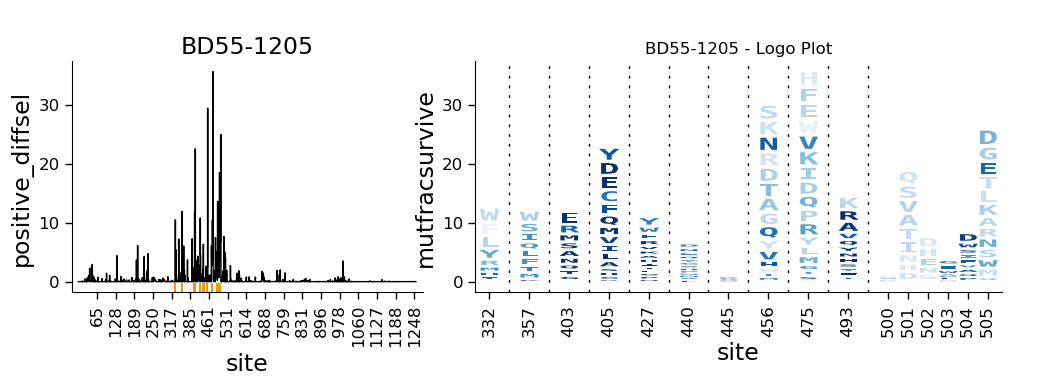

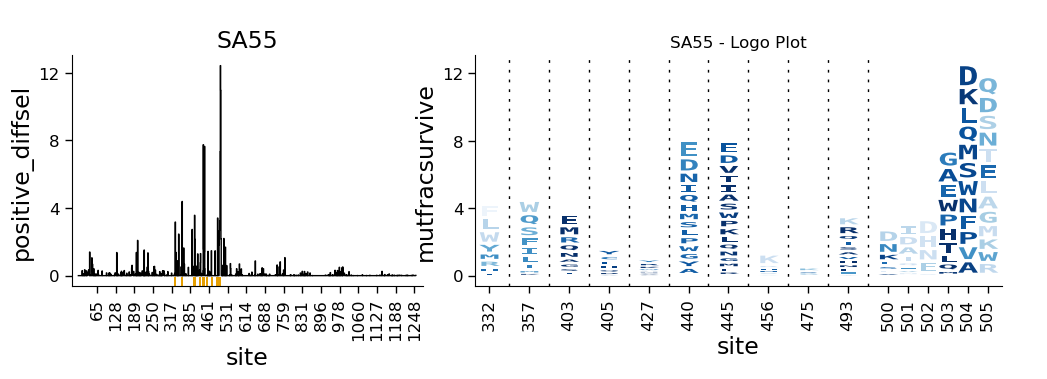

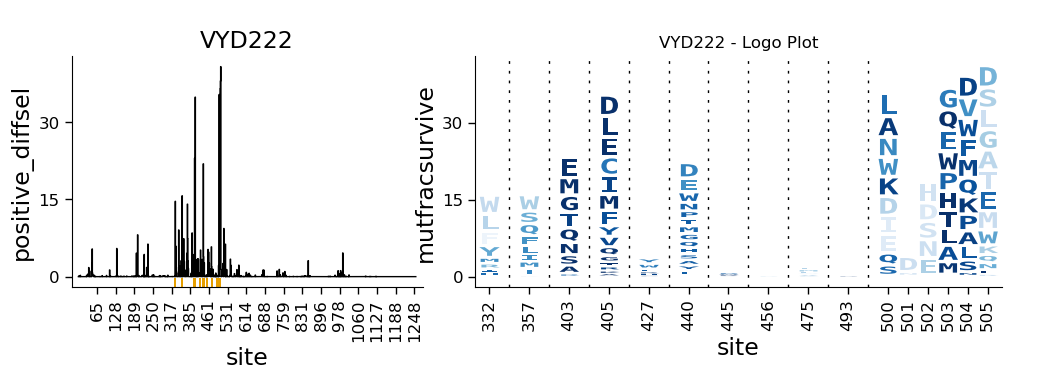

In [6]:
# Ensure 'site' is numeric 
filtered_df = filtered_df[filtered_df['site'].apply(lambda x: str(x).isdigit())].copy()
filtered_df['site'] = filtered_df['site'].astype(int)

# Melt to long format
antibody_cols = ['BD55-1205', 'SA55', 'VYD222']
long_df = filtered_df.melt(
    id_vars=['site', 'wildtype', 'mutant', 'color'],
    value_vars=antibody_cols,
    var_name='antibody',
    value_name='mutfracsurvive'
)

long_df = long_df.rename(columns={'mutant': 'mutation'})

# Compute site total escape
long_df['totfracsurvive'] = long_df.groupby(['antibody', 'site'])['mutfracsurvive'].transform('sum')

# Step 4: Add positive_diffsel
long_df['positive_diffsel'] = long_df['totfracsurvive'].clip(lower=0)

# Mark top 10 sites per antibody 
# Initialize show_site column
long_df['show_site'] = False

# Store all top 10 sites for each antibody
all_top_sites = set()

# First: mark top 10 per antibody and collect global top sites
for ab in antibody_cols:
    top_sites = (
        long_df[long_df['antibody'] == ab]
        .groupby('site')['totfracsurvive']
        .mean()
        .nlargest(10)
        .index
    )
    all_top_sites.update(top_sites)
    long_df.loc[(long_df['antibody'] == ab) & (long_df['site'].isin(top_sites)), 'show_site'] = True

# Second: also mark True if site is among the top 10 for any antibody
long_df.loc[long_df['site'].isin(all_top_sites), 'show_site'] = True


# Plot per antibody 
for ab in antibody_cols:
    df_ab = long_df.query('antibody == @ab').copy()

    # Map site to sequential integers for x_col
    unique_sites = sorted(df_ab['site'].unique())
    site_map = {s: i+1 for i, s in enumerate(unique_sites)}
    df_ab['isite'] = df_ab['site'].map(site_map)

    # Create figure
    fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 1.5]})
    fig.subplots_adjust(wspace=0.12)
    fig.set_size_inches(12, 3)

    # Line plot (left) using positive_diffsel
    dmslogo.draw_line(
        df_ab,
        x_col="isite",
        height_col="positive_diffsel",
        xtick_col="site",
        show_col="show_site",
        ax=axes[0],
        title=f"{ab}"
    )

    # Logo plot (right) for top 10 sites
    dmslogo.draw_logo(
        df_ab.query("show_site"),
        x_col="isite",
        letter_col="mutation",
        letter_height_col="mutfracsurvive",
        clip_negative_heights=True,
        color_col="color",
        ax=axes[1],
        xtick_col="site",
    )
    axes[1].set_title(f"{ab} - Logo Plot")

    plt.show()

    # save svg
    svg_path = os.path.join("results/escape_logos",f"{ab}_line_logo_plot.svg")
    fig.savefig(svg_path, format="svg", bbox_inches="tight")
    print(f"Saved {svg_path}")

    plt.close(fig)